In [1]:
%load_ext autoreload
%autoreload 2

## Imports, top level definitions and data loading

In [4]:
import keras_lmu
import pandas as pd
import os
import tensorflow as tf
import numpy as np

from core.pre_processing import build_ohio_dataset, build_windows, get_patient_window
from core.utils import compile_and_fit, plot_loss

In [6]:
# Path where to store the trained models
root_path = "models"

SAMPL_FREQ = 5

PATIENTS_2018 = ["559", "563", "570", "575", "588", "591"]
PATIENTS_2020 = ["540", "544", "552", "567", "584", "596"]

model_name = "lmu_2020_ph60min"

In [7]:
dataset_all_2018_full = build_ohio_dataset("all", pretrain_on_2018_train_only=False)

Using time to peak: 100 for patient 559
Identified 42 gaps for train set of 559
Identified 11 gaps for val set of 559
Identified 0 gaps for test set of 559
Using time to peak: 100 for patient 563
Identified 21 gaps for train set of 563
Identified 3 gaps for val set of 563
Identified 0 gaps for test set of 563
Using time to peak: 100 for patient 570
Identified 20 gaps for train set of 570
Identified 9 gaps for val set of 570
Identified 0 gaps for test set of 570
Using time to peak: 100 for patient 575
Identified 68 gaps for train set of 575
Identified 14 gaps for val set of 575
Identified 0 gaps for test set of 575
Using time to peak: 100 for patient 588
Identified 10 gaps for train set of 588
Identified 2 gaps for val set of 588
Identified 0 gaps for test set of 588
Using time to peak: 100 for patient 591
Identified 26 gaps for train set of 591
Identified 4 gaps for val set of 591
Identified 0 gaps for test set of 591
Using time to peak: 100 for patient 540
Identified 22 gaps for train

## Setup params for the model and input

In [9]:
# 12 steps -> 60 minutes prediction horizon
PH = 12
batch_size = 256

# 30 minutes of input
input_len = 30

features = ["Time", "Glucose", "Rapid Insulin sub_tissue", "Carbohydrates gut", "finger_stick"]

## Create pre-processed input-target pairs for the model
Additionally create input-target pairs per each patient so that we can evaluate the performance individually per patient

In [23]:
w_2020, _ = build_windows(dataset_all_2018_full, features, input_len // SAMPL_FREQ, 1, PH, drop_noisy=False, batch_size=batch_size, min_max_scale=False)

In [24]:
patient_windows_2020 = {}
for p_tr_df, p_v_df, p_tst_df, patient_id in dataset_all_2018_full:
    if patient_id not in PATIENTS_2020:
        continue
    patient_windows_2020[patient_id] = get_patient_window(
        (p_tr_df, p_v_df, p_tst_df),
        features,
        input_len // SAMPL_FREQ,
        1,
        PH,
        drop_noisy=False,
        batch_size=batch_size,
        min_max_scale=False
    )

In [18]:
len(patient_windows_2020)

6

## Train and evaluate models

In [25]:
def train_model(patient_windows, model_name: str, train_window):
    lmu_layer = keras_lmu.LMU(
        memory_d=4,
        order=64,
        theta=input_len // SAMPL_FREQ,
        hidden_to_memory=False,
        memory_to_memory=False,
        input_to_hidden=True,
        hidden_cell=tf.keras.layers.LSTMCell(units=156),
        return_sequences=False,
        dropout=0.1,
        recurrent_dropout=0.1,
    )
    inputs = tf.keras.Input((input_len // SAMPL_FREQ, 4))
    lmus = lmu_layer(inputs)
    outputs = tf.keras.layers.Dense(1)(lmus)
    output_plus_input = tf.keras.layers.Add()([outputs, inputs[:, -1, 0]])

    model = tf.keras.Model(inputs=inputs, outputs=output_plus_input)
    print(model.summary())

    history = compile_and_fit(model, train_window, max_epochs=300, learning_rate=10**-3, patience=35, store_model=model_name)
    plot_loss(history, "Loss", False)

    best_model = tf.keras.models.load_model(os.path.join(root_path, model_name))

    results_val = []
    results_test = []

    for patient_id, patient_w in patient_windows.items():
        print("Evaluating on patient_id:", patient_id)
        val_p = best_model.evaluate(patient_w.val, verbose=0)[1]
        test_p = best_model.evaluate(patient_w.test, verbose=0)[1]
        results_val.append((model_name, patient_id, val_p))
        results_test.append((model_name, patient_id, test_p))
    return results_val, results_test

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 6, 4)]               0         []                            
                                                                                                  
 lmu_2 (LMU)                 (None, 156)                  260224    ['input_3[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 1)                    157       ['lmu_2[0][0]']               
                                                                                                  
 tf.__operators__.getitem_2  (None,)                      0         ['input_3[0][0]']             
  (SlicingOpLambda)                                                                         

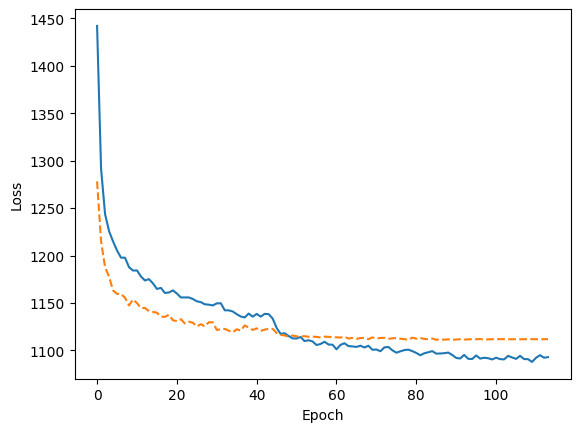

In [26]:
val_errs, test_errs = train_model(patient_windows_2020, f"{model_name}_0", w_2020)

In [27]:
print(np.average([rmse for _, _, rmse in test_errs]))

32.51544920603434


## Get statistics for multiple training runs

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 6, 4)]               0         []                            
                                                                                                  
 lmu_3 (LMU)                 (None, 156)                  260224    ['input_4[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 1)                    157       ['lmu_3[0][0]']               
                                                                                                  
 tf.__operators__.getitem_3  (None,)                      0         ['input_4[0][0]']             
  (SlicingOpLambda)                                                                         

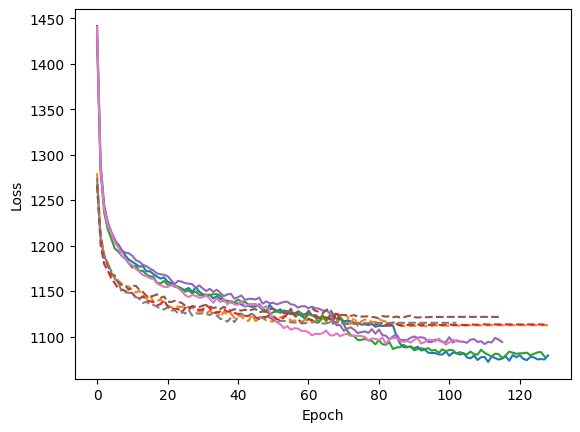

In [28]:
# 4 more runs
for i in range(1, 5):
    cur_val_errs, cur_test_errs = train_model(patient_windows_2020, f"{model_name}_{i}", w_2020)
    test_errs.extend(cur_test_errs)
    val_errs.extend(cur_val_errs)

In [29]:
test_errs

[('lmu_2020_ph60min_0', '540', 37.64949035644531),
 ('lmu_2020_ph60min_0', '544', 28.609895706176758),
 ('lmu_2020_ph60min_0', '552', 28.878225326538086),
 ('lmu_2020_ph60min_0', '567', 36.202571868896484),
 ('lmu_2020_ph60min_0', '584', 35.789146423339844),
 ('lmu_2020_ph60min_0', '596', 27.96336555480957),
 ('lmu_2020_ph60min_1', '540', 37.614280700683594),
 ('lmu_2020_ph60min_1', '544', 28.522714614868164),
 ('lmu_2020_ph60min_1', '552', 28.989530563354492),
 ('lmu_2020_ph60min_1', '567', 35.941654205322266),
 ('lmu_2020_ph60min_1', '584', 35.866336822509766),
 ('lmu_2020_ph60min_1', '596', 28.04759979248047),
 ('lmu_2020_ph60min_2', '540', 37.58872985839844),
 ('lmu_2020_ph60min_2', '544', 28.872243881225586),
 ('lmu_2020_ph60min_2', '552', 29.086294174194336),
 ('lmu_2020_ph60min_2', '567', 36.12700271606445),
 ('lmu_2020_ph60min_2', '584', 35.72757339477539),
 ('lmu_2020_ph60min_2', '596', 27.795114517211914),
 ('lmu_2020_ph60min_3', '540', 37.93570327758789),
 ('lmu_2020_ph60min

In [30]:
val_errs

[('lmu_2020_ph60min_0', '540', 36.237342834472656),
 ('lmu_2020_ph60min_0', '544', 27.816871643066406),
 ('lmu_2020_ph60min_0', '552', 35.16578674316406),
 ('lmu_2020_ph60min_0', '567', 41.98384094238281),
 ('lmu_2020_ph60min_0', '584', 48.437034606933594),
 ('lmu_2020_ph60min_0', '596', 23.45256996154785),
 ('lmu_2020_ph60min_1', '540', 36.240142822265625),
 ('lmu_2020_ph60min_1', '544', 28.116653442382812),
 ('lmu_2020_ph60min_1', '552', 34.99889373779297),
 ('lmu_2020_ph60min_1', '567', 42.21881103515625),
 ('lmu_2020_ph60min_1', '584', 48.26860809326172),
 ('lmu_2020_ph60min_1', '596', 23.45293617248535),
 ('lmu_2020_ph60min_2', '540', 36.41201400756836),
 ('lmu_2020_ph60min_2', '544', 27.869054794311523),
 ('lmu_2020_ph60min_2', '552', 35.13534164428711),
 ('lmu_2020_ph60min_2', '567', 42.0724983215332),
 ('lmu_2020_ph60min_2', '584', 48.272743225097656),
 ('lmu_2020_ph60min_2', '596', 23.475854873657227),
 ('lmu_2020_ph60min_3', '540', 36.46242141723633),
 ('lmu_2020_ph60min_3', 

In [31]:
df_results_test = pd.DataFrame(test_errs, columns=['Model iteration', 'Patient ID', 'RMSE'])
df_results_test['Model'] = df_results_test['Model iteration'].str.replace(r'_\d+$', '', regex=True)

df_results_test.groupby(['Model iteration'])['RMSE'].agg(['mean'])

,mean
Model iteration,
lmu_2020_ph60min_0,32.515449
lmu_2020_ph60min_1,32.497019
lmu_2020_ph60min_2,32.532826
lmu_2020_ph60min_3,32.730032
lmu_2020_ph60min_4,32.593218


In [32]:
df_results_test.groupby(['Model iteration', 'Model'])['RMSE'].agg(['mean']).groupby("Model").agg(["mean", "std"])

mean          
                       mean       std
Model                                
lmu_2020_ph60min  32.573709  0.094557

In [33]:
df_results_test.groupby(['Patient ID'])['RMSE'].agg(["mean", "std"])

,mean,std
Patient ID,,
540,37.701045,0.139750
544,28.717158,0.171481
552,28.982064,0.107057
567,36.132831,0.145043
584,35.904995,0.160378
596,28.004161,0.134429
